## Introduction
This dataset was given to try different classification algorithms and models to explore which gives best accuracy

The target is to predict whether a student is going to graduate or not

The dataset contains outliers but no null or nan values and all values are numerical except target variable

## Loading the Data

In [1]:
# Imprting needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Exploratory Data Analysis (EDA)

In [4]:
# Dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
df.shape

(5110, 12)

In [7]:
categorical = [col for col in df.columns if df[col].dtype=='O']
print('Columns that contain categerical data: ',categorical)

Columns that contain categerical data:  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


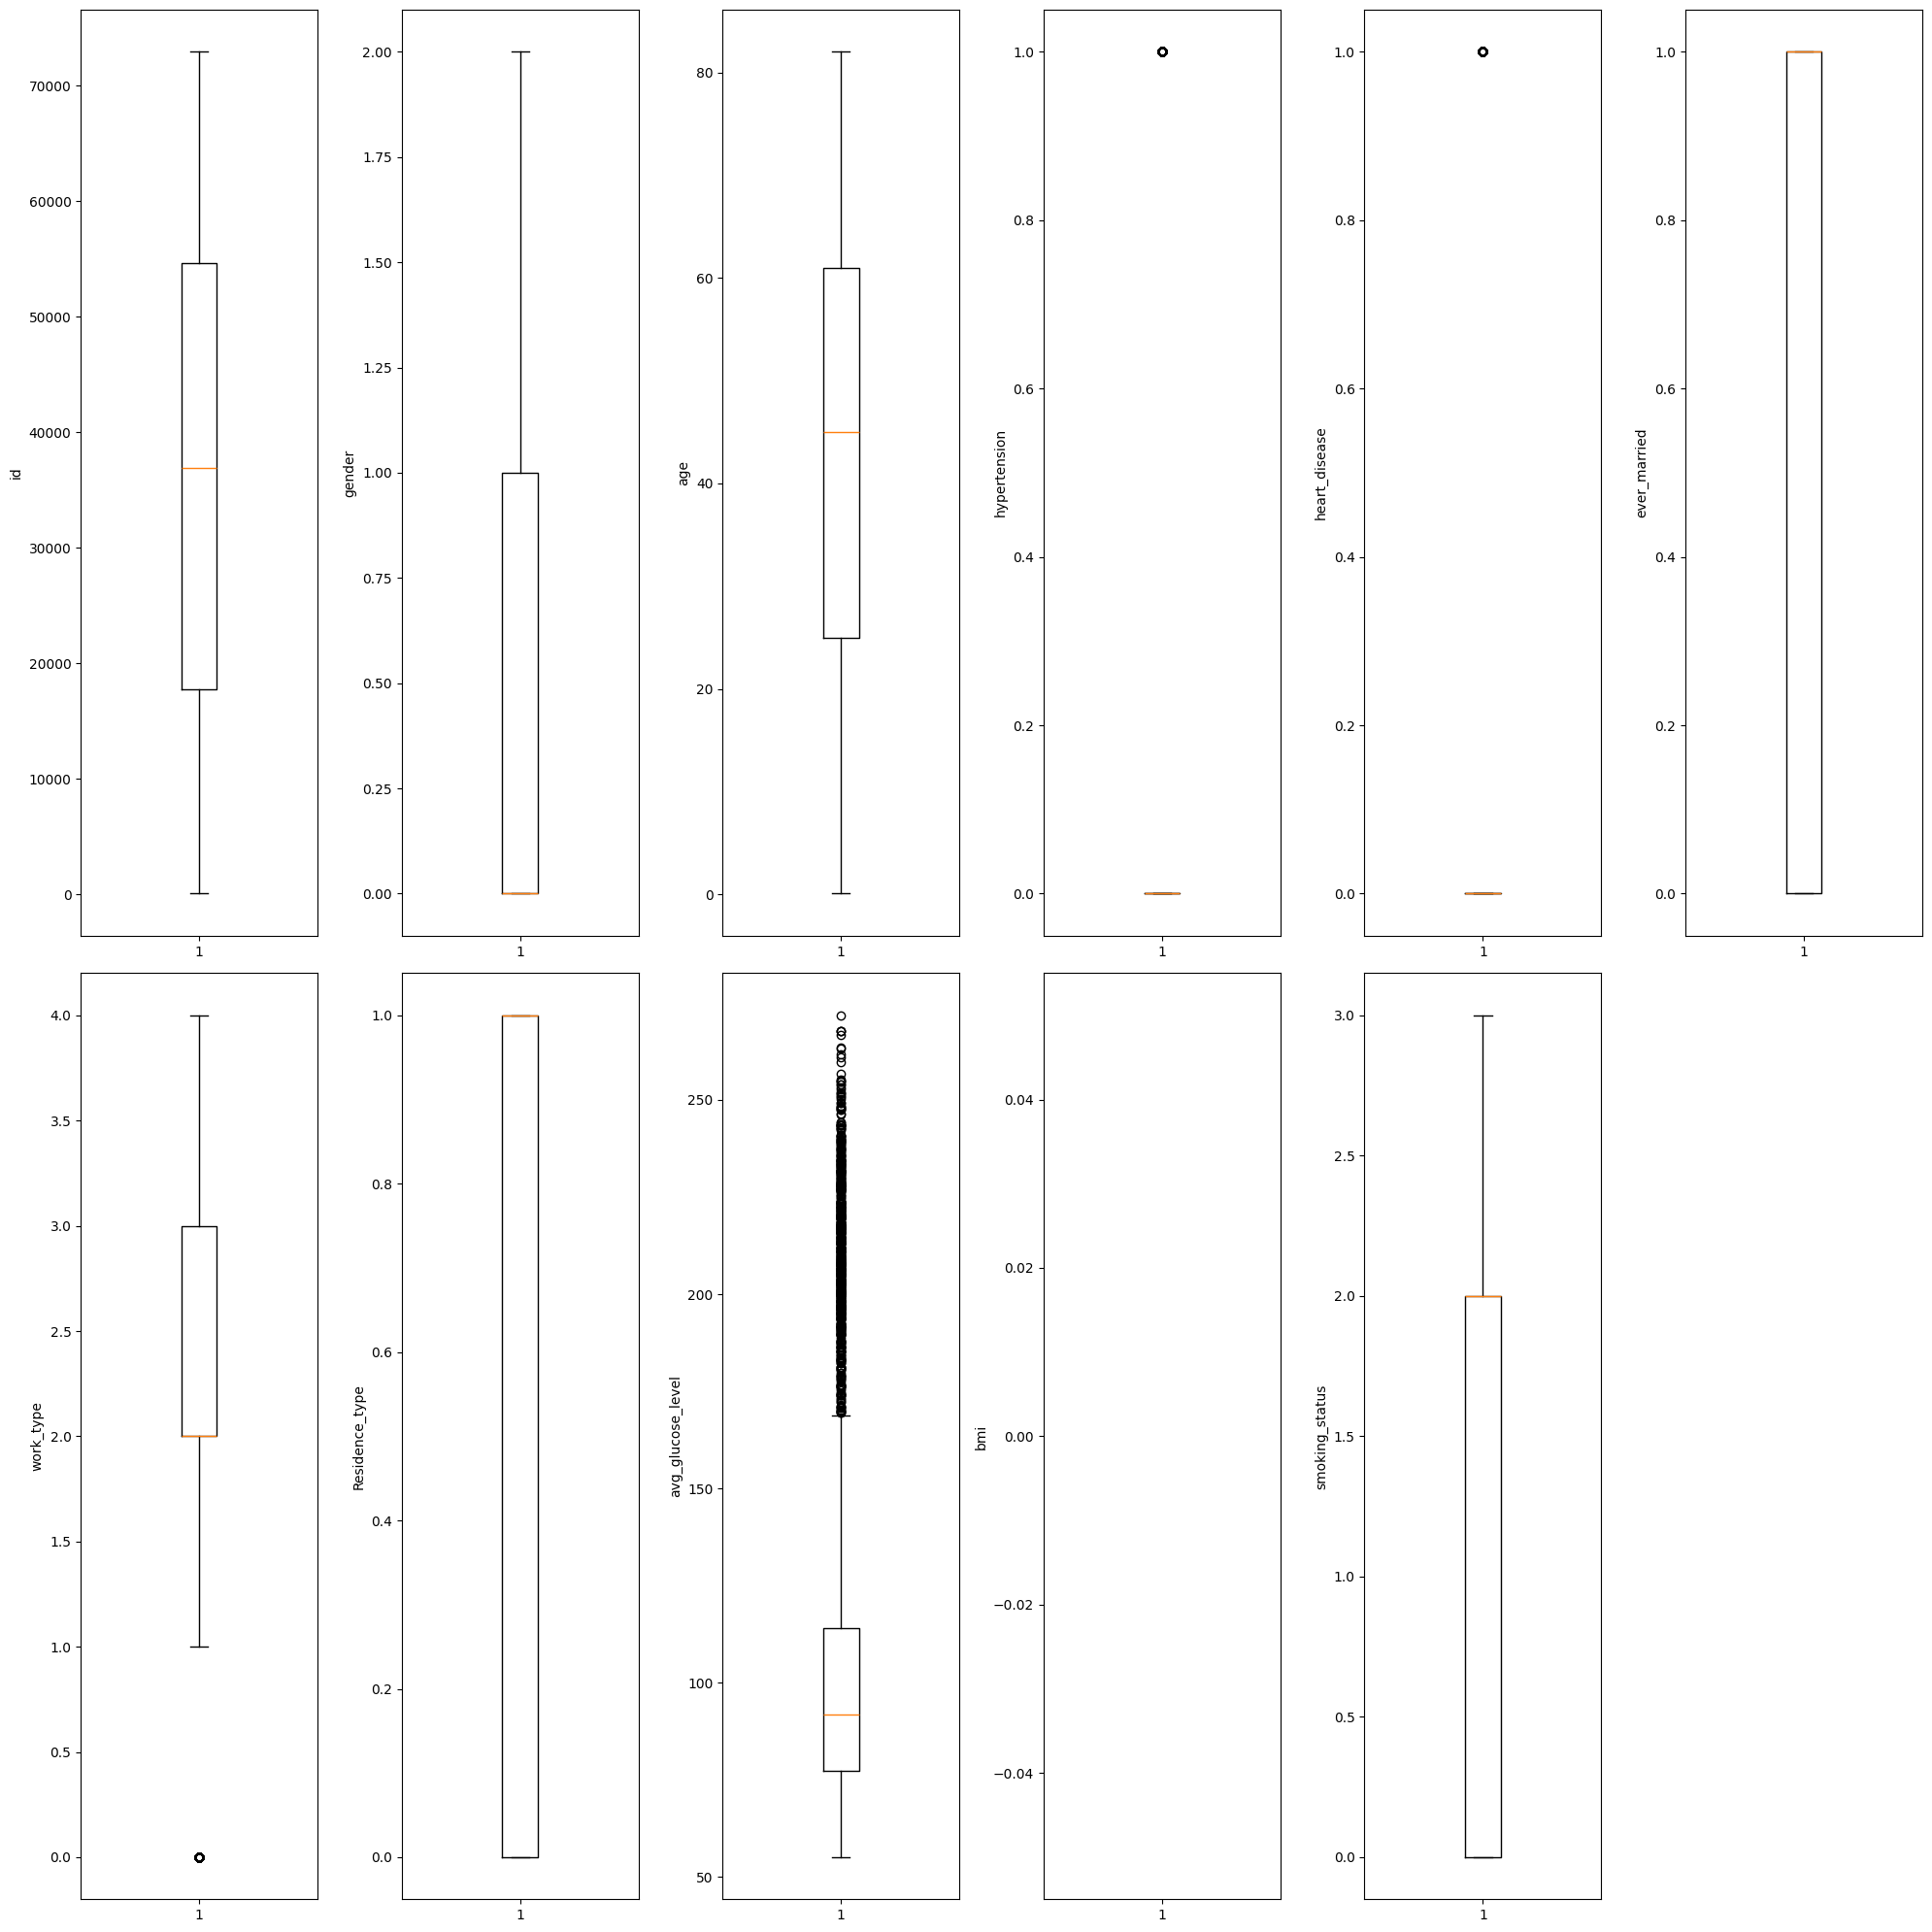

In [8]:
# Check Feature distribution & outliers
plt.figure( figsize=(20,20))
df_copy = df.drop('stroke', axis=1)

le = LabelEncoder()
df_copy = df_copy.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

num_columns = len(df_copy.columns)
rows = num_columns // 6 + (num_columns % 6 > 0)

i = 1
for col in df_copy.columns:
    plt.subplot(rows, 6, i)
    plt.boxplot(df_copy[col]) 
    plt.ylabel(str(col)) 
    i += 1  

plt.tight_layout()
plt.show()


In [9]:
## Target class distribution
target_distribution = df['stroke'].value_counts()

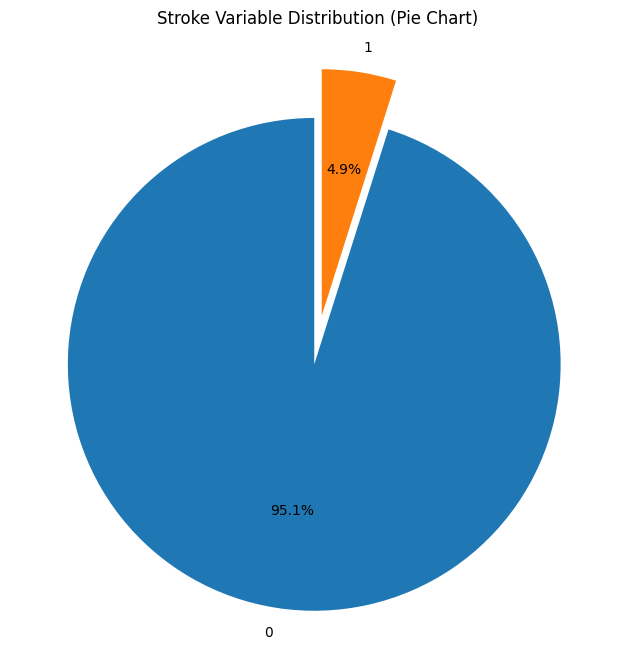

In [10]:
explode = [0.1] * len(target_distribution)   # this defines a margin for each target class
plt.figure(figsize=(8, 8))
target_distribution.plot.pie(autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Stroke Variable Distribution (Pie Chart)')
plt.ylabel('')
plt.show()

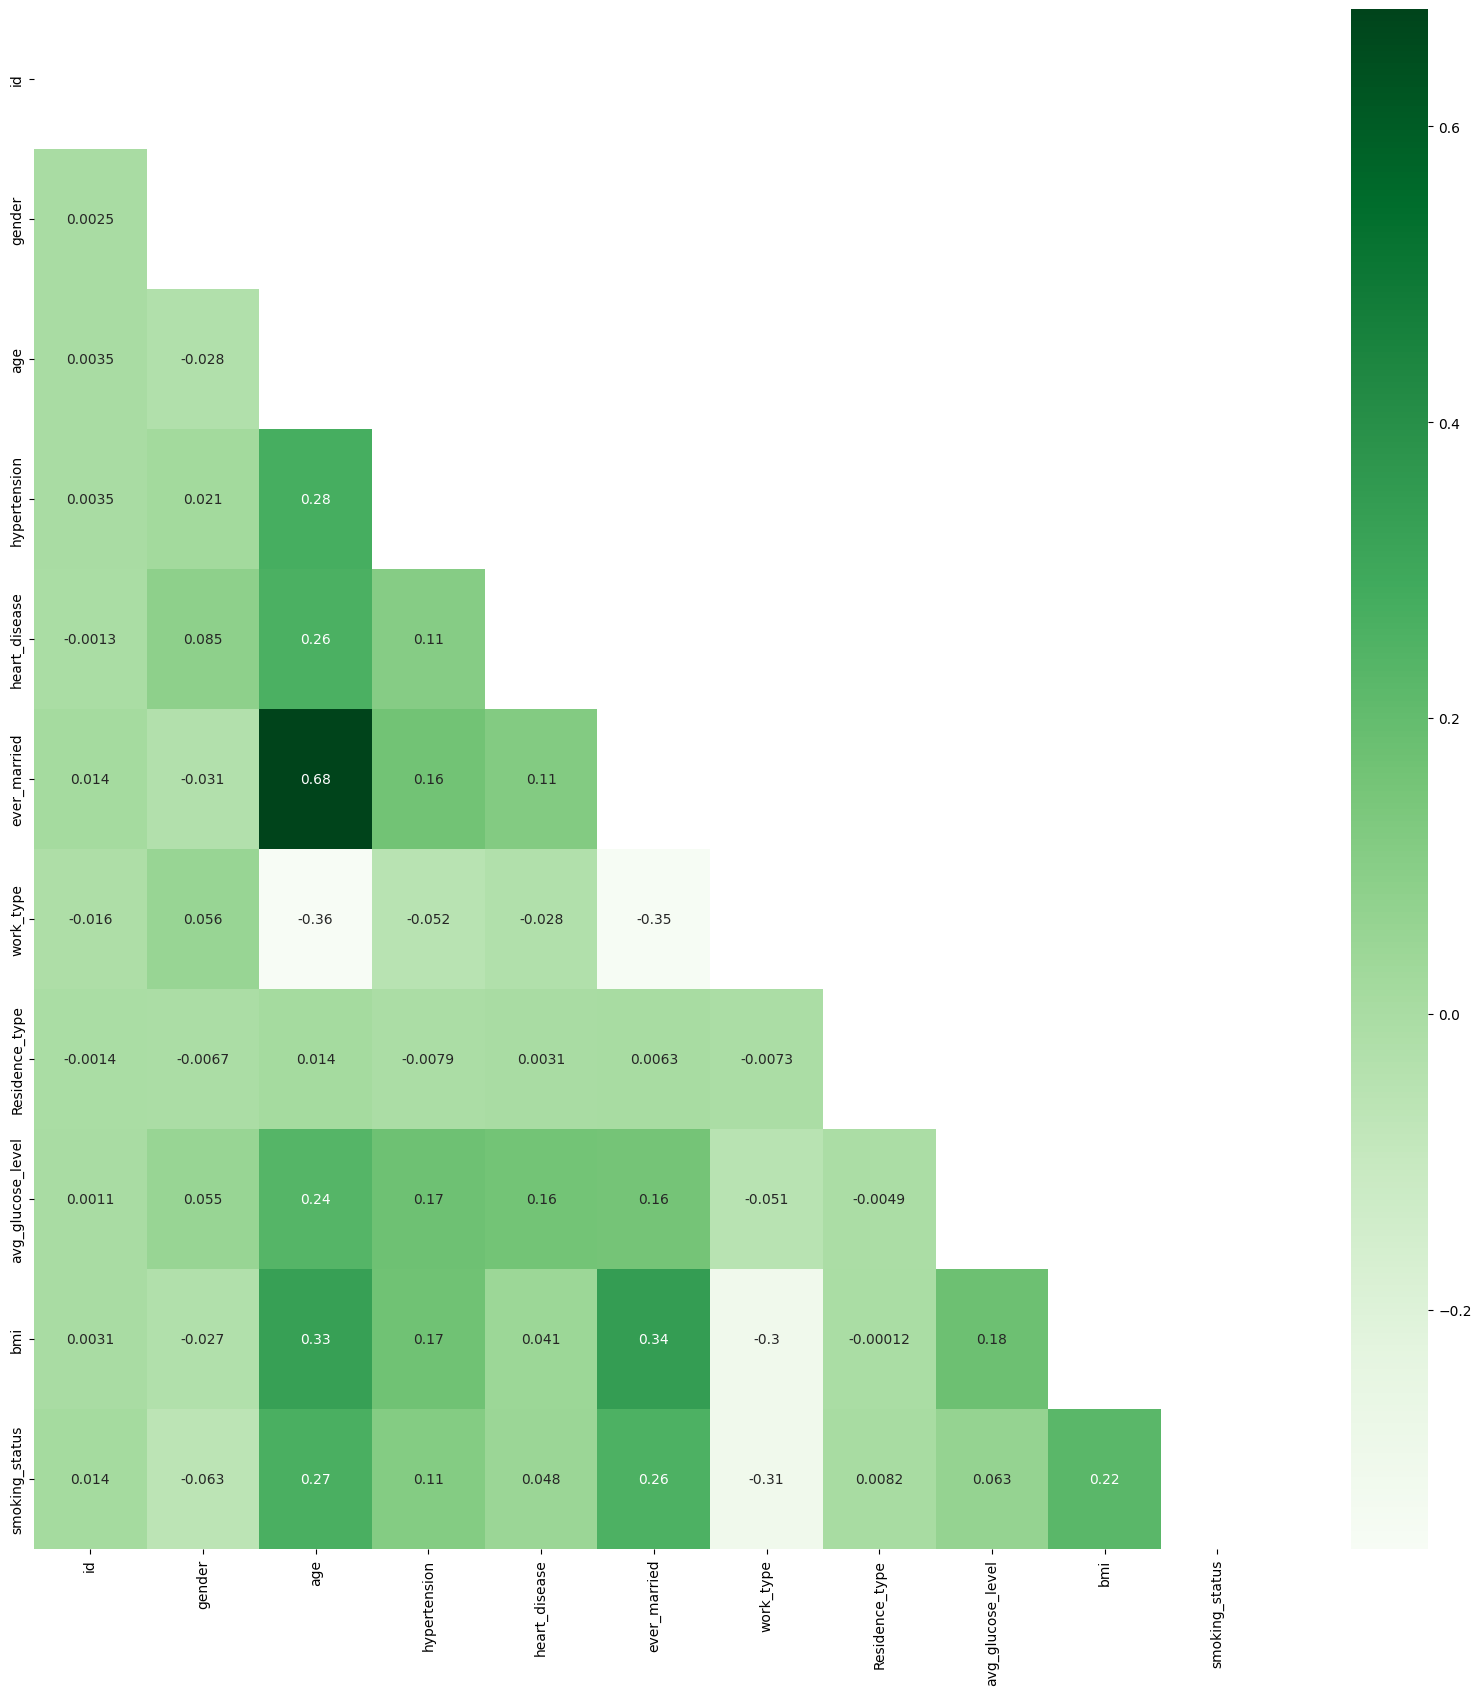

In [11]:
corr_matrix = df_copy.corr(numeric_only=True)
plt.figure( figsize=(20,20))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='Greens', mask=mask)

plt.show()


In [12]:
df.isna().sum().any()

True

In [13]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [14]:
df.duplicated().sum().any()

#df = df[df.duplicated(keep=False)]

False

## Data cleaning



In [15]:
# Fill NaN values

le = LabelEncoder()
df = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)
df_copy = df
df_copy['bmi'].fillna(df_copy['bmi'].median(), inplace=True)

In [16]:
df_copy.drop(['id'],axis=1,inplace=True)

## Outlier Removal

In [17]:
## 2_Removing outliers with interquartile range method
df_copy = df
for col in df.select_dtypes(include=['number']).columns:
    if col=='stroke':
        break
    IQR = df_copy[col].quantile(0.90) - df_copy[col].quantile(0.10)
    Lower_fence = df_copy[col].quantile(0.10) - (IQR * 3) 
    Upper_fence = df_copy[col].quantile(0.90) + (IQR * 3) 
    
    df_copy = df_copy[(df_copy[col] >= Lower_fence) & (df_copy[col] <= Upper_fence)]

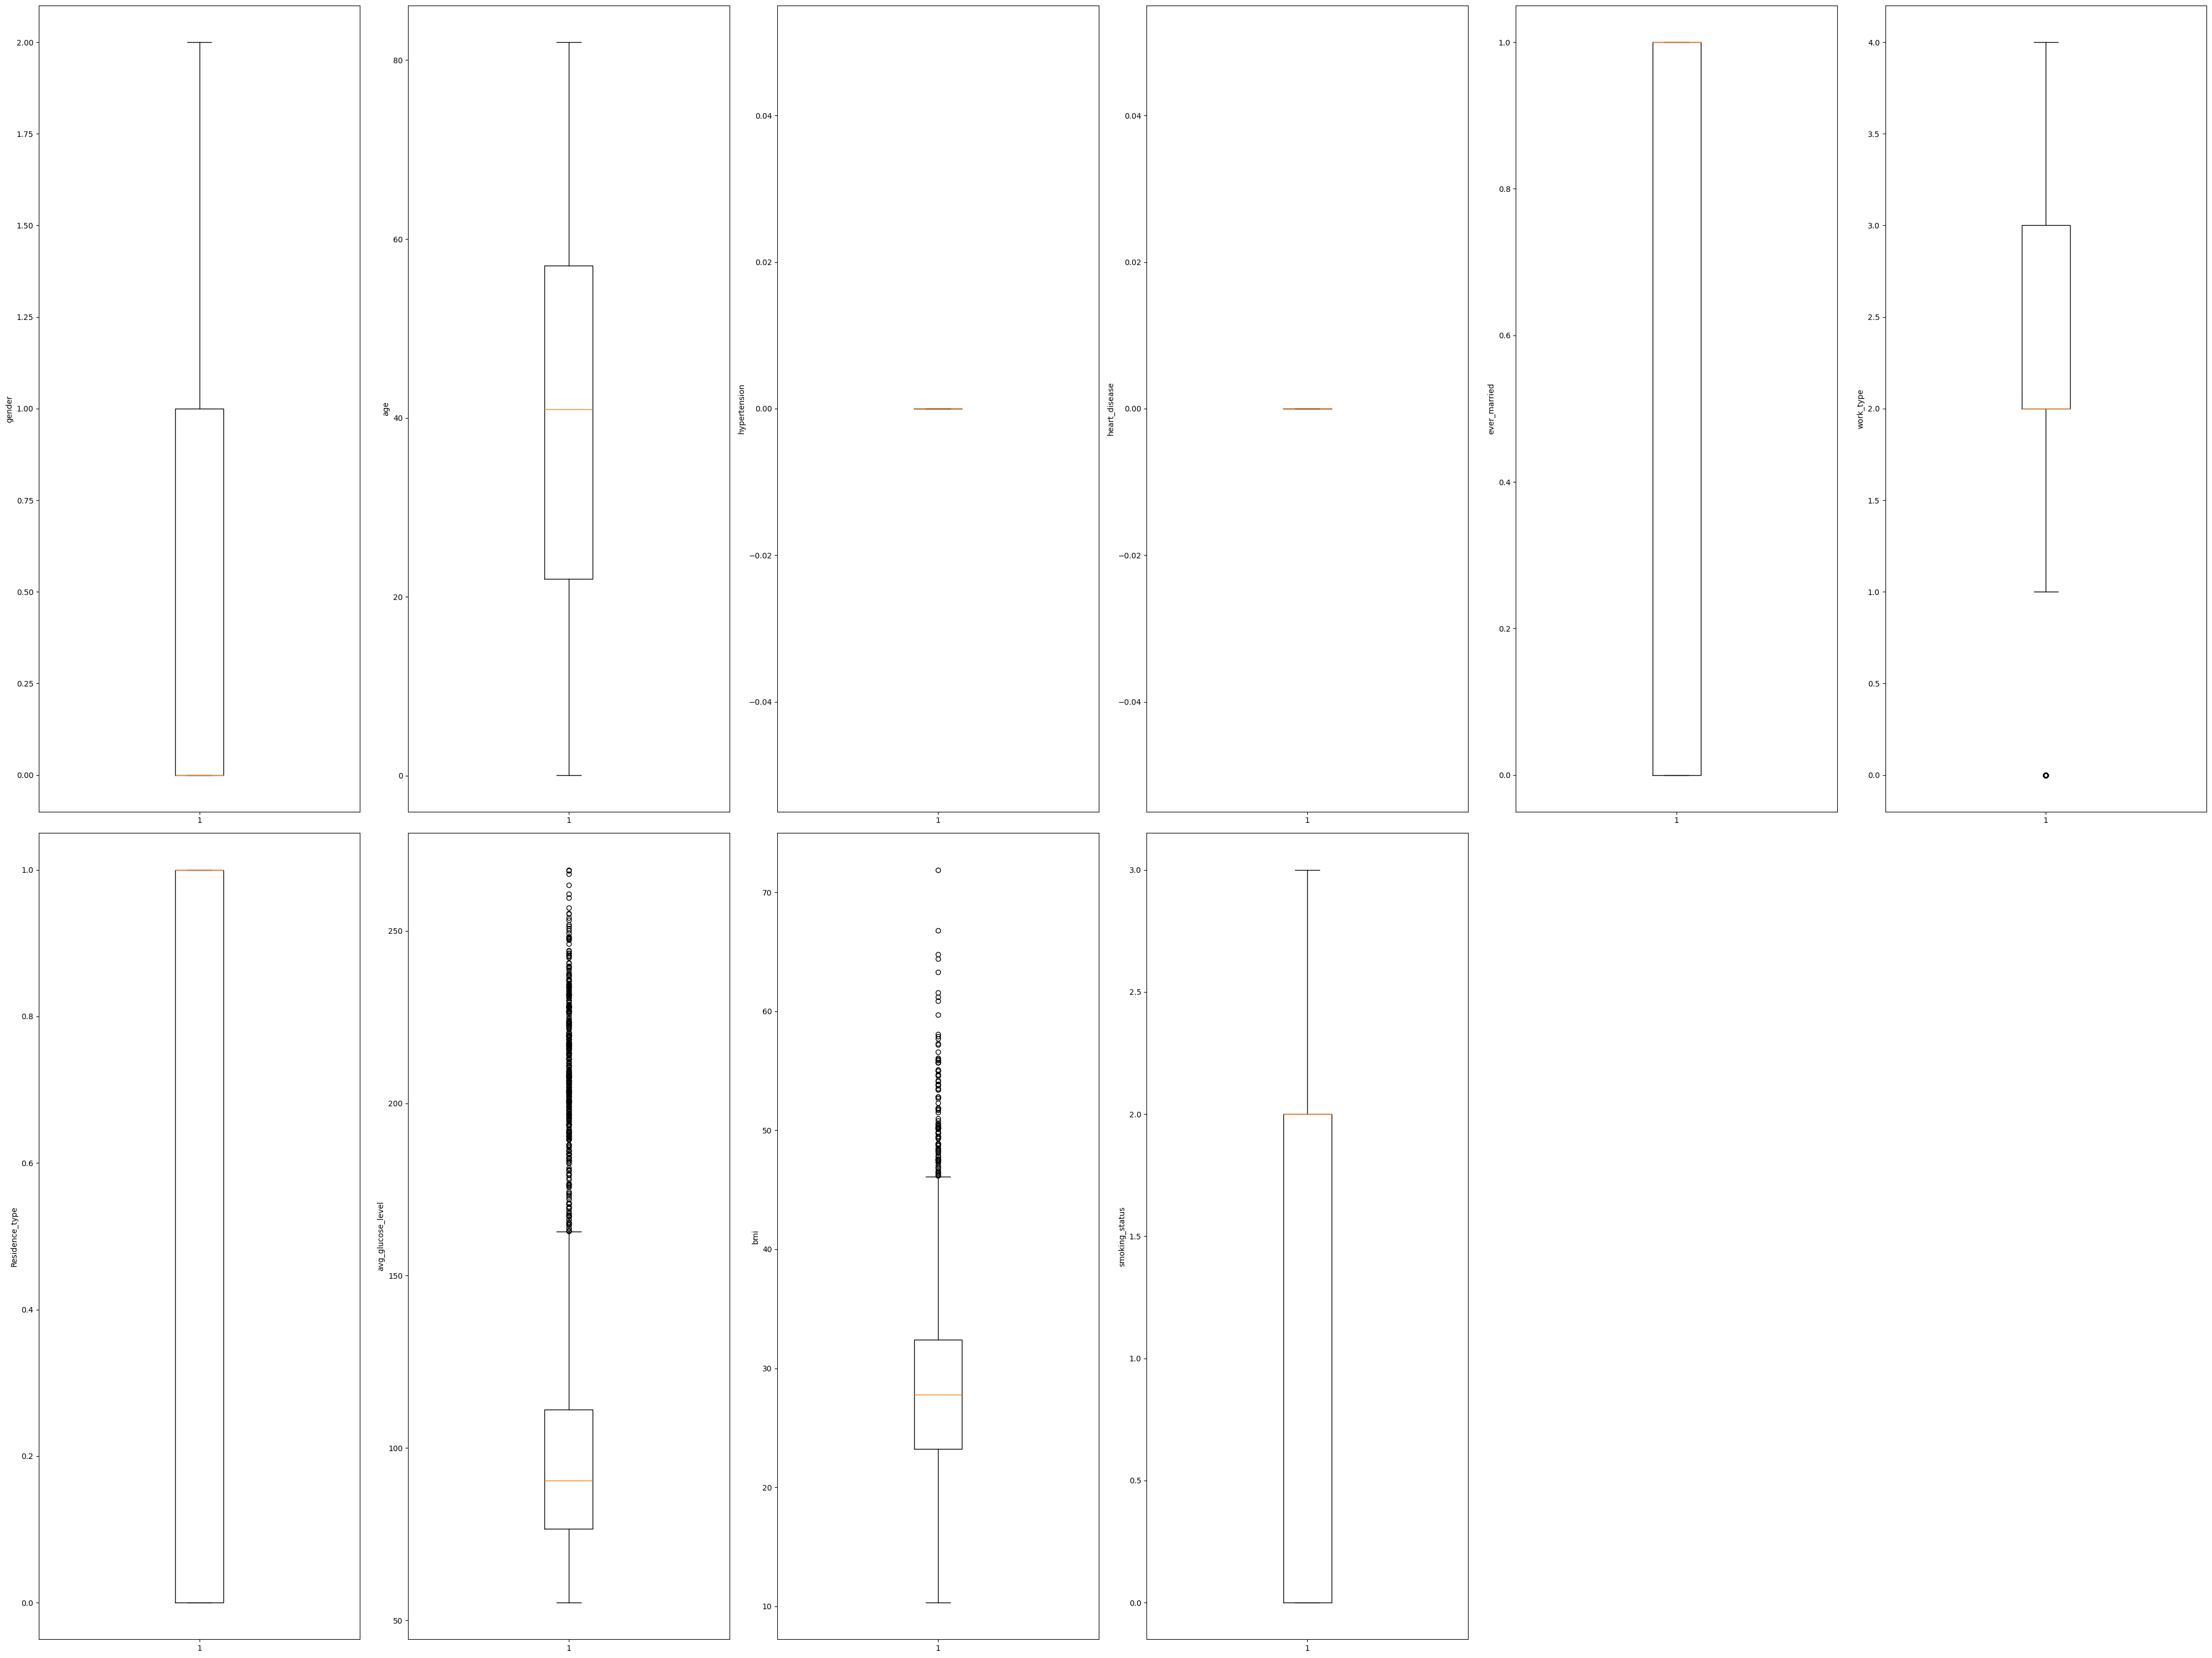

In [18]:
# Check Feature distribution & outliers
plt.figure(figsize=(40, 30))

num_columns = len(df_copy.columns)
rows = num_columns // 6 + (num_columns % 6 > 0)

i = 1
for col in df_copy.columns:
    if col == 'stroke':
        break
    plt.subplot(rows, 6, i)
    plt.boxplot(df_copy[col]) 
    plt.ylabel(str(col)) 
    i += 1  

plt.tight_layout()
plt.show()


In [19]:
df_copy.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [20]:
# more outlier removal from columns [ work_type, avg_glucose_level, bmi]
outlier_columns = ['work_type', 'avg_glucose_level', 'bmi']
for col in outlier_columns:
    
    IQR = df_copy[col].quantile(0.60) - df_copy[col].quantile(0.40)
    Lower_fence = df_copy[col].quantile(0.60) - (IQR * 3) 
    Upper_fence = df_copy[col].quantile(0.40) + (IQR * 3) 
    
    df_copy = df_copy[(df_copy[col] >= Lower_fence) & (df_copy[col] <= Upper_fence)]

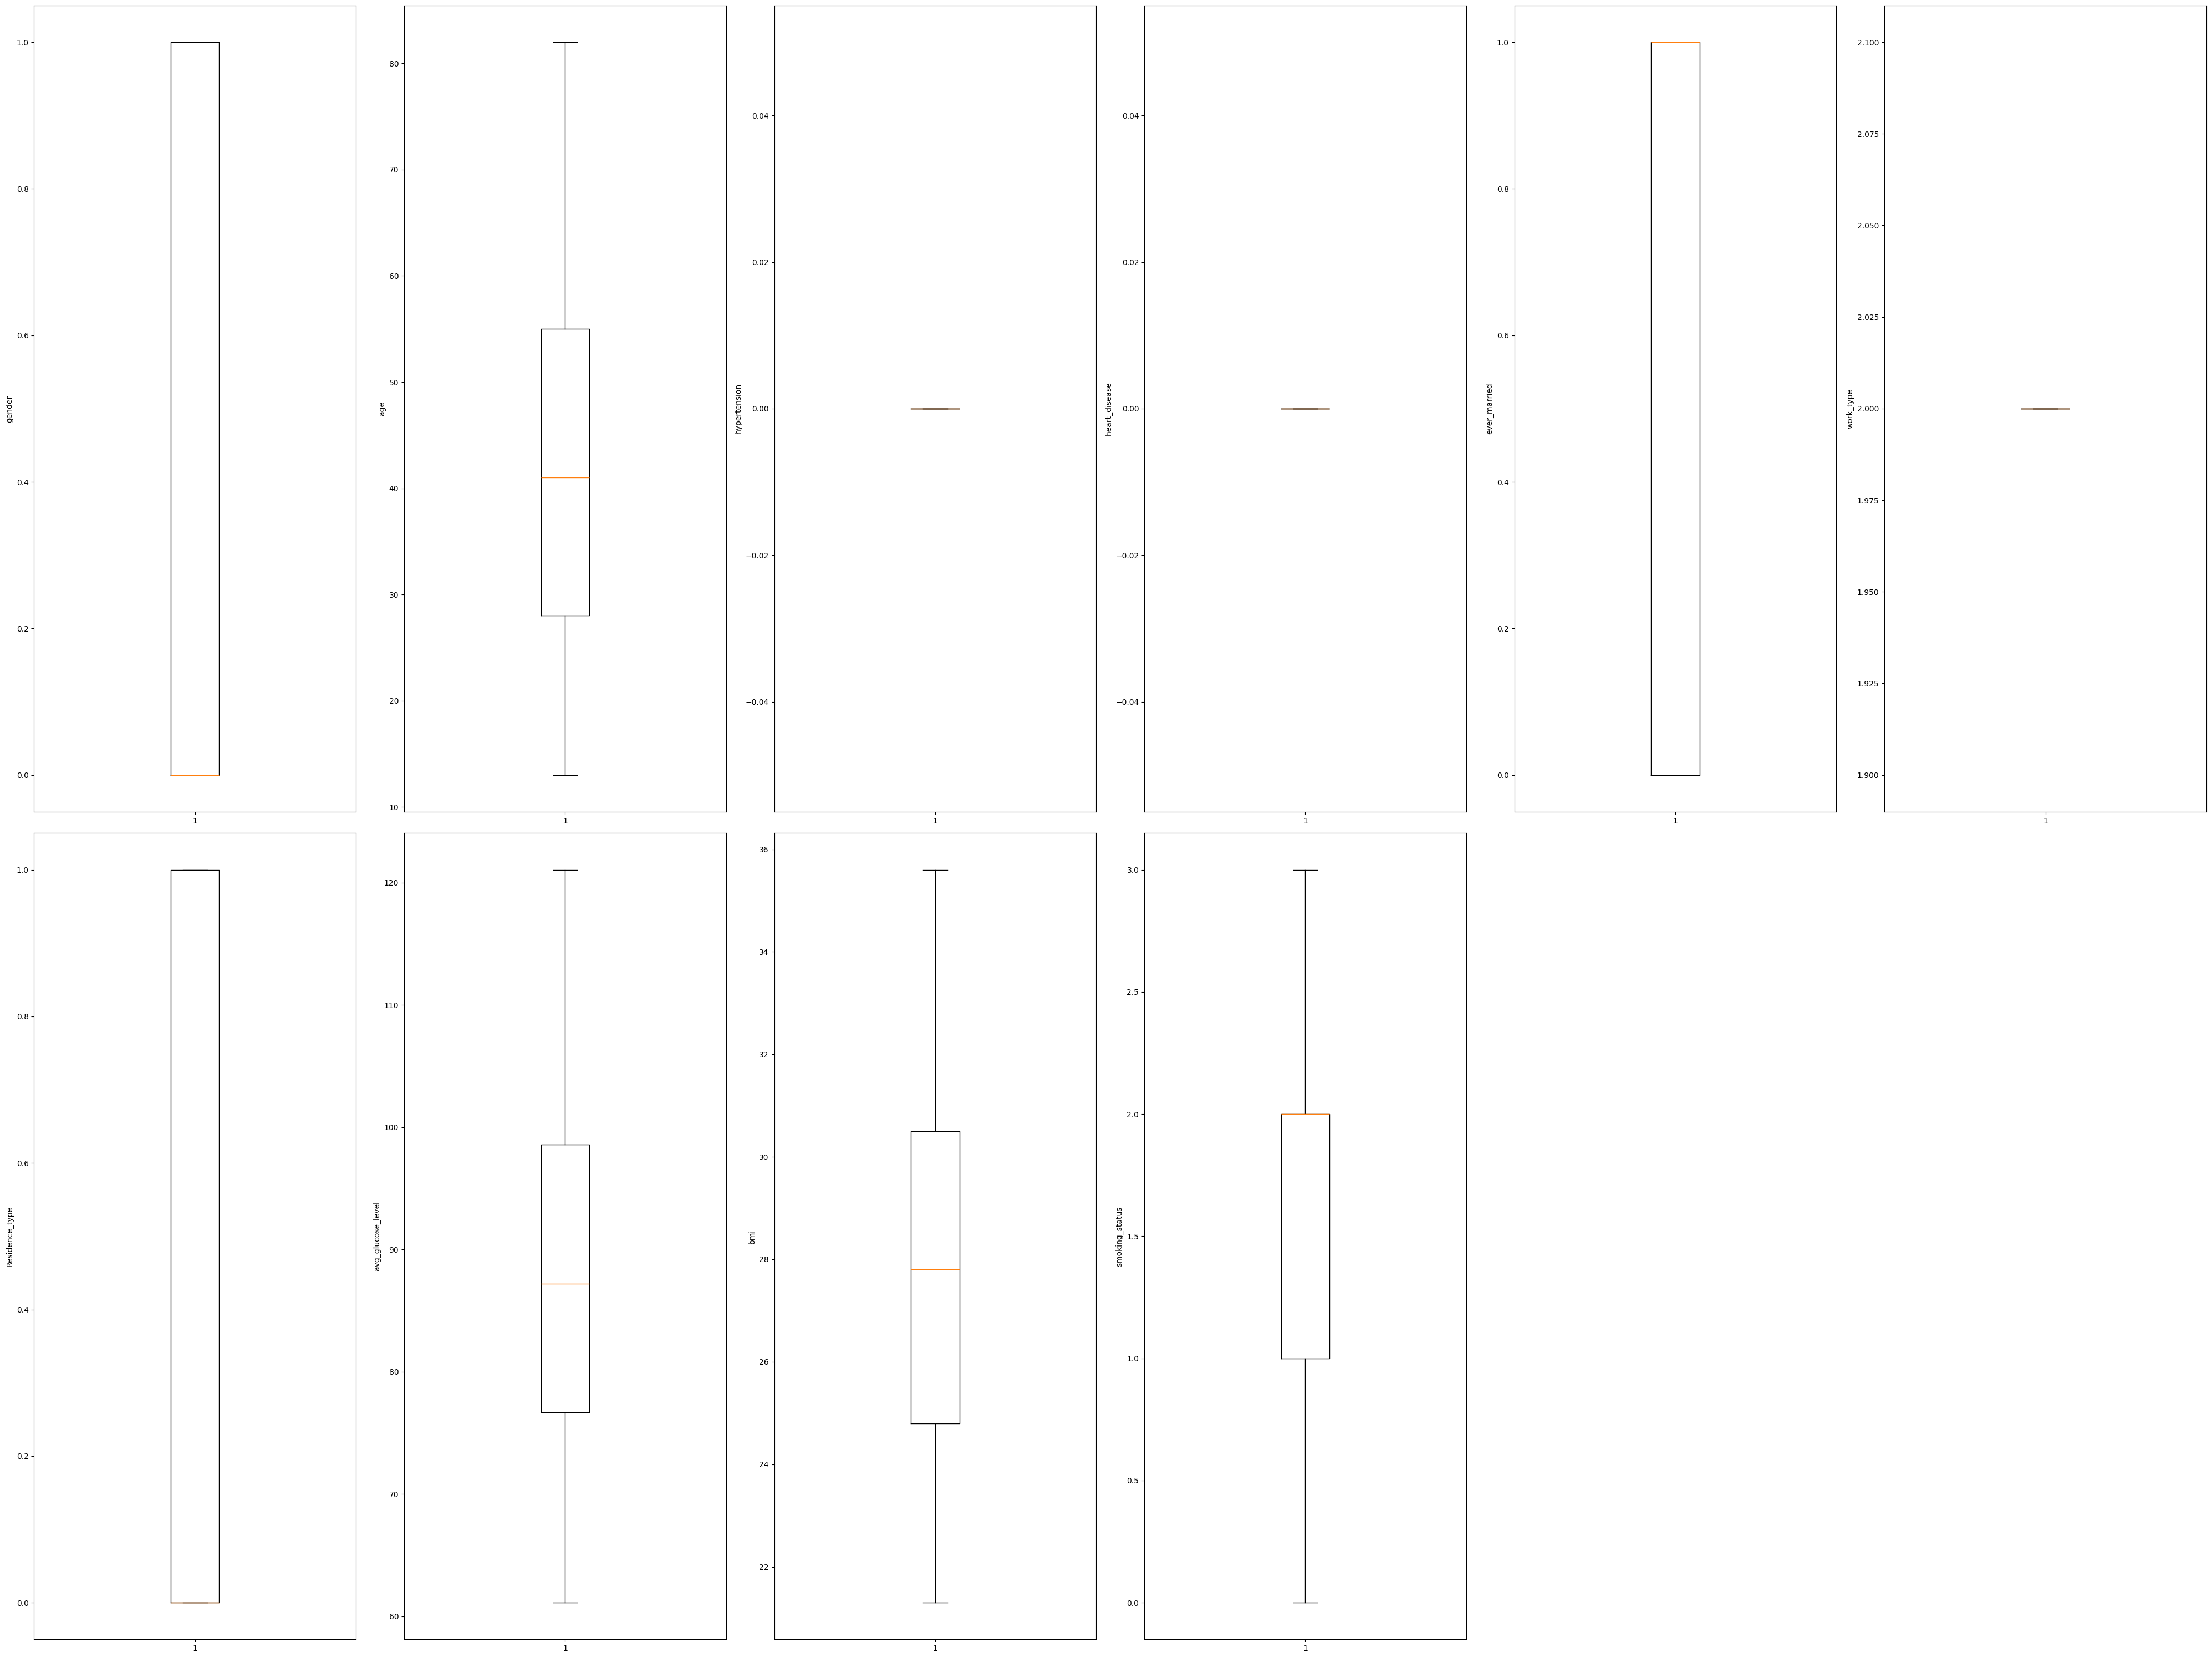

In [21]:
# Check Feature distribution & outliers
plt.figure(figsize=(40, 30))

num_columns = len(df_copy.columns)
rows = num_columns // 6 + (num_columns % 6 > 0)

i = 1
for col in df_copy.columns:
    if col == 'stroke':
        break
    plt.subplot(rows, 6, i)
    plt.boxplot(df_copy[col]) 
    plt.ylabel(str(col)) 
    i += 1  

plt.tight_layout()
plt.show()


## Splitting data for feature extraction

In [22]:
X = df_copy.drop('stroke', axis=1)
y = df_copy['stroke']


y_encoded = pd.DataFrame(y, columns = ['stroke'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Feature Selection With RFE

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression()

rfe = RFE(estimator=model)


rfe.fit(X_train_scaled, y_train)


selected_features = X.columns[rfe.support_]


In [24]:
print('original features num: ',len(df.columns))
print('selected features num: ',selected_features.shape[0])

original features num:  11
selected features num:  5


In [25]:
df_rfe = df_copy[selected_features]

In [26]:
df_rfe.columns

Index(['gender', 'age', 'Residence_type', 'avg_glucose_level', 'bmi'], dtype='object')

## Scaling the dataset

In [27]:
scaler = StandardScaler()
df_rfe = scaler.fit_transform(df_rfe)
df_rfe = pd.DataFrame(df_rfe, columns=selected_features)


In [28]:
df_rfe.describe()

,gender,age,Residence_type,avg_glucose_level,bmi
count,1.457000e+03,1.457000e+03,1.457000e+03,1.457000e+03,1.457000e+03
mean,9.753504e-17,1.560561e-16,1.219188e-17,-3.816058e-16,-1.302093e-15
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-8.190675e-01,-1.671609e+00,-9.682458e-01,-1.821953e+00,-1.762898e+00
25%,-8.190675e-01,-8.210943e-01,-9.682458e-01,-7.753588e-01,-8.099523e-01
50%,-8.190675e-01,-8.398130e-02,-9.682458e-01,-6.821841e-02,6.858143e-03
75%,1.220901e+00,7.098327e-01,1.032796e+00,6.967300e-01,7.419876e-01
max,1.220901e+00,2.240760e+00,1.032796e+00,2.206461e+00,2.130565e+00


## Splitting the dataset for training

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_rfe, y, test_size=0.2, random_state=42)

## Balancing the dataset
Gave bad results accuracy 0.76 and without it got 0.97

In [30]:
print("Class distribution before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", Counter(y_train_balanced))

Class distribution before SMOTE: Counter({0: 1125, 1: 40})
Class distribution after SMOTE: Counter({0: 1125, 1: 1125})


## Model -- Logistic regression

In [31]:
model = LogisticRegression(multi_class='ovr')
#model.fit(X_train_balanced, y_train_balanced)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       0.00      0.00      0.00         7

    accuracy                           0.98       292
   macro avg       0.49      0.50      0.49       292
weighted avg       0.95      0.98      0.96       292



## Model -- SVM

In [33]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

train_predictions = svc.predict(X_train)
test_predictions = svc.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

train_f1_macro = f1_score(y_train, train_predictions, average='macro')
test_f1_macro = f1_score(y_test, test_predictions, average='macro')

train_conf_matrix = confusion_matrix(y_train, train_predictions)
test_conf_matrix = confusion_matrix(y_test, test_predictions)

results = {
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Train F1 Macro": train_f1_macro,
    "Test F1 Macro": test_f1_macro,
    "Train Confusion Matrix": train_conf_matrix,
    "Test Confusion Matrix": test_conf_matrix
}

results

{'Train Accuracy': 0.9656652360515021,
 'Test Accuracy': 0.976027397260274,
 'Train F1 Macro': 0.4912663755458515,
 'Test F1 Macro': 0.49393414211438474,
 'Train Confusion Matrix': array([[1125,    0],
        [  40,    0]], dtype=int64),
 'Test Confusion Matrix': array([[285,   0],
        [  7,   0]], dtype=int64)}

## Model -- KNN

In [35]:
K = 20
error =[]
accuracy=[]
for i in range(1,K+1):
    knn= KNeighborsClassifier(n_neighbors= i)
    knn.fit(X_train, y_train)
    y_pred =knn.predict(X_test)
    error.append(1-metrics.accuracy_score(y_test,y_pred))
    accuracy.append(metrics.accuracy_score(y_test,y_pred))


Text(0.5, 1.0, 'accuracy vs K')

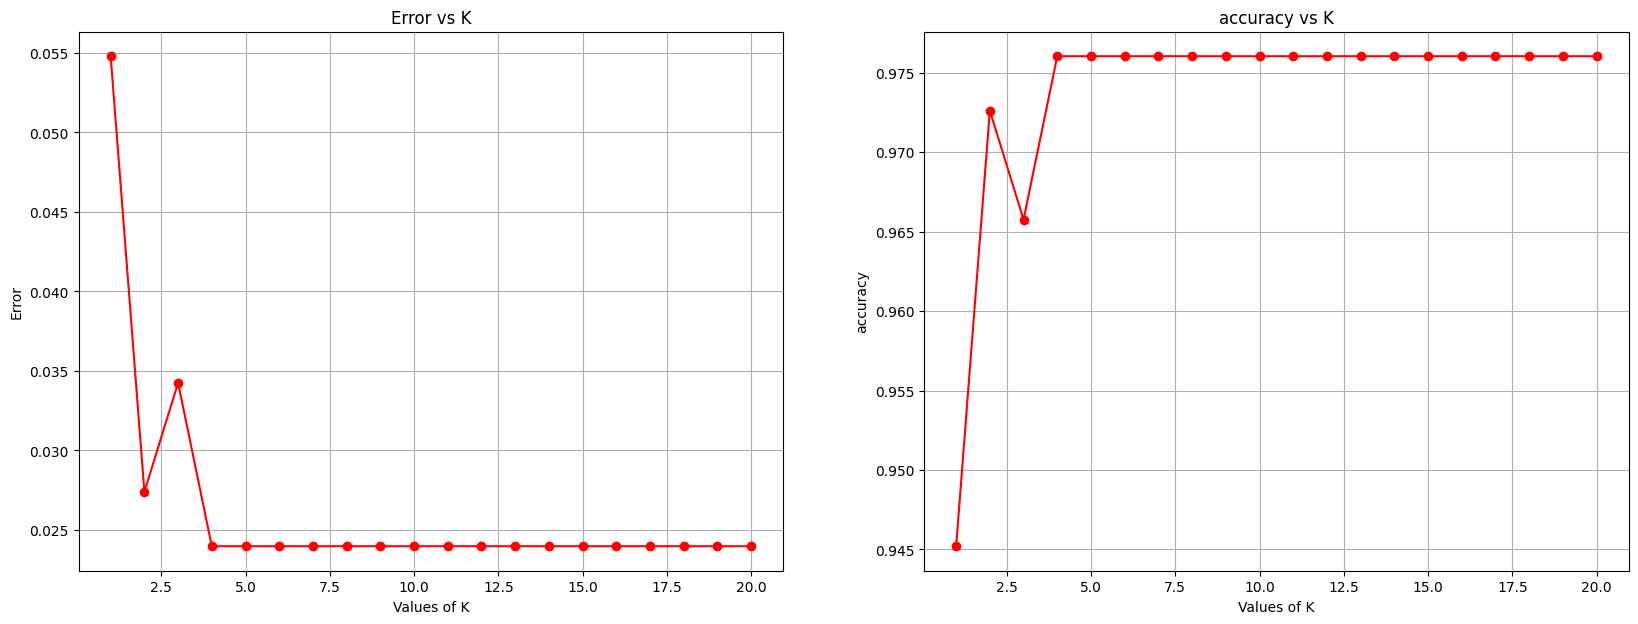

In [36]:

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),error,'r-',marker='o')
plt.xlabel('Values of K')
plt.ylabel('Error')
plt.grid()
plt.title('Error vs K')

plt.subplot(1, 2, 2)
plt.plot(range(1,21),accuracy,'r-',marker='o')
plt.xlabel('Values of K')
plt.ylabel('accuracy')
plt.grid()
plt.title('accuracy vs K')

In [37]:
K=2
clf= KNeighborsClassifier(K)
#clf.fit(X_train_balanced, y_train_balanced)
clf.fit(X_train, y_train)
y_pred =clf.predict(X_test)
print("Accuracy :" ,metrics.accuracy_score(y_test,y_pred))

Accuracy : 0.9726027397260274


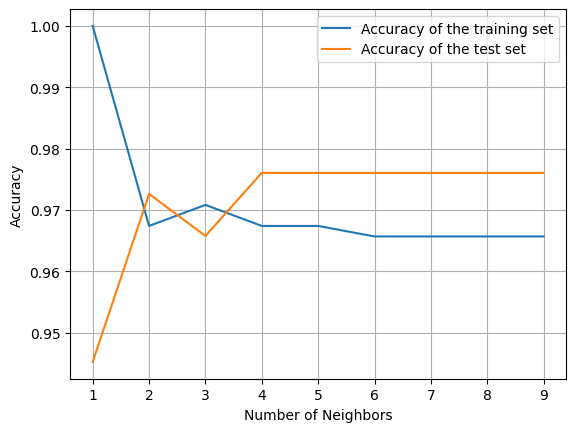

In [38]:
training_acc = []
test_acc = []

neighbors_setting = range(1,10)
for n_neighbors in neighbors_setting:
    knn= KNeighborsClassifier(n_neighbors= n_neighbors, )
    knn.fit(X_train,y_train)
    training_acc.append(knn.score(X_train,y_train))
    test_acc.append(knn.score(X_test,y_test))

plt.plot(neighbors_setting,training_acc,label='Accuracy of the training set')
plt.plot(neighbors_setting,test_acc,label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.grid()
plt.legend()
plt.show()

## apply all single  (Logistic regression,  KNN, Naive bayies, SVM, Decision tree), ensemble (RF, Extratrees, bagging m XGBoosting , gradient boosting , adaboost , voting , and stacking) ML models usign grid search

In [40]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import AdaBoostClassifier

balancing_techniques = {
    'No Resampling': None,
    'SMOTE': SMOTE(random_state=42),
    'Random Over-Sampling': RandomOverSampler(random_state=42),
    'Random Under-Sampling': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Single Models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

# Ensemble Models
ensemble_models = {
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Hyperparameter Grids (Example - Customize for each model)
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {}, # Add an empty dictionary for Naive Bayes since it doesn't usually require hyperparameter tuning
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Bagging': {'n_estimators': [10, 20, 30]},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model Evaluation and Selection
best_models = {}

for name, sampler in balancing_techniques.items():
    print(f"--- {name} ---")
    
    if sampler is not None:
        # Apply the balancing technique
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        print(f"Resampled dataset shape: {Counter(y_resampled)}")
    else:
        # No resampling, use the original dataset
        X_resampled, y_resampled = X_train, y_train

    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy')
        grid_search.fit(X_resampled, y_resampled)
        best_models[name] = grid_search.best_estimator_
        print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")

    for name, model in ensemble_models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy')
        grid_search.fit(X_resampled, y_resampled)
        best_models[name] = grid_search.best_estimator_
        print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")

    # Voting and Stacking (Example - Customize estimators and voting method)
    estimators = [('rf', best_models['Random Forest']), ('xgb', best_models['XGBoost'])]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')  # or 'hard'
    voting_clf.fit(X_resampled, y_resampled)
    best_models['Voting'] = voting_clf

    # Evaluate Best Models on Test Set
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print(f"--- {name} ---")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")


--- No Resampling ---
Logistic Regression: Best Parameters - {'C': 0.1}, Best Score - 0.9656652360515021
KNN: Best Parameters - {'n_neighbors': 7}, Best Score - 0.9656652360515021
Naive Bayes: Best Parameters - {}, Best Score - 0.9656652360515021
SVM: Best Parameters - {'C': 0.1, 'kernel': 'linear'}, Best Score - 0.9656652360515021
Decision Tree: Best Parameters - {'max_depth': 5}, Best Score - 0.9570815450643778
Random Forest: Best Parameters - {'n_estimators': 200}, Best Score - 0.9656652360515021
Extra Trees: Best Parameters - {'n_estimators': 100}, Best Score - 0.9622317596566525
Bagging: Best Parameters - {'n_estimators': 30}, Best Score - 0.9605150214592275
AdaBoost: Best Parameters - {'n_estimators': 200}, Best Score - 0.9579399141630901
Gradient Boosting: Best Parameters - {'n_estimators': 100}, Best Score - 0.9570815450643776
XGBoost: Best Parameters - {'learning_rate': 0.01, 'n_estimators': 50}, Best Score - 0.9656652360515021
--- Logistic Regression ---
Accuracy: 0.976027397

| Classifier         | Balancing Algorithm | Best Parameters                           | Best Score       | Accuracy          | Precision (0) | Recall (0) | F1-Score (0) | Precision (1) | Recall (1) | F1-Score (1) |
|--------------------|---------------------|-------------------------------------------|-------------------|-------------------|---------------|------------|---------------|---------------|------------|---------------|
| **Logistic Regression** | SMOTETomek          | `{'C': 10}`                             | `0.8024`          | `0.6884`          | 0.98          | 0.69       | 0.81          | 0.04          | 0.57       | 0.08          |
| **KNN**                | SMOTETomek          | `{'n_neighbors': 3}`                     | `0.9170`          | `0.8425`          | 0.98          | 0.86       | 0.91          | 0.05          | 0.29       | 0.08          |
| **Naive Bayes**        | SMOTETomek          |                                           | `0.8309`          | `0.7158`          | 0.99          | 0.72       | 0.83          | 0.05          | 0.57       | 0.09          |
| **SVM**                | SMOTETomek          | `{'C': 10, 'kernel': 'rbf'}`            | `0.9120`          | `0.8219`          | 0.98          | 0.84       | 0.90          | 0.02          | 0.14       | 0.04          |
| **Decision Tree**      | SMOTETomek          | `{'max_depth': None}`                    | `0.9089`          | `0.8836`          | 0.98          | 0.90       | 0.94          | 0.06          | 0.29       | 0.11          |
| **Random Forest**      | SMOTETomek          | `{'n_estimators': 50}`                   | `0.9393`          | `0.8836`          | 0.98          | 0.90       | 0.94          | 0.03          | 0.14       | 0.06          |
| **Extra Trees**        | SMOTETomek          | `{'n_estimators': 50}`                   | `0.9488`          | `0.8836`          | 0.98          | 0.90       | 0.94          | 0.03          | 0.14       | 0.06          |
| **Bagging**            | SMOTETomek          | `{'n_estimators': 20}`                   | `0.9334`          | `0.8733`          | 0.98          | 0.89       | 0.93          | 0.03          | 0.14       | 0.05          |
| **AdaBoost**           | SMOTETomek          | `{'n_estimators': 200}`                  | `0.8640`          | `0.7979`          | 0.99          | 0.80       | 0.89          | 0.07          | 0.57       | 0.12          |
| **Gradient Boosting**  | SMOTETomek          | `{'n_estimators': 200}`                  | `0.9143`          | `0.8630`          | 0.98          | 0.87       | 0.93          | 0.08          | 0.43       | 0.13          |
| **XGBoost**            | SMOTETomek          | `{'learning_rate': 0.2, 'n_estimators': 200}` | `0.9288`   | `0.8836`          | 0.98          | 0.89       | 0.94          | 0.09          | 0.43       | 0.15          |
| **Voting Classifier**  | SMOTETomek          |                                           |                   | `0.8767`          | 0.98          | 0.89       | 0.93          | 0.09          | 0.43       | 0.14          |


### Summary of Accuracy
- **Overall Performance**: No resampling shows the highest accuracy, but balancing techniques like SMOTE and SMOTEENN enhances minority class detection.